### CS303 - Mathematical Foundations for AI
# Coding Assignment

--- 

#### __Problem 2. (Derivative-Free Optimization Methods).__ This assignment explores __Nelder-Mead, Simulated Annealing__, and __Covariance Matrix Adaptation Evolution Strategy (CMA-ES)__. You will implement these optimization techniques and compare their performance on different objective functions. Implement or use available libraries to apply the following optimization techniques:
- __Nelder-Mead__ (Simplex Method)
- __Simulated Annealing__
- __CMA-ES (Covariance Matrix Adaptation Evolution Strategy)__

Ensure that each method is applied with appropriate hyperparameters.

In [1]:
import numpy as np
from scipy.optimize import minimize, dual_annealing
import matplotlib.pyplot as plt
import cma
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV
from mpl_toolkits.mplot3d import Axes3D


#### __Task 1__: Benchmarking on Test Functions (1 mark)
1. Optimize the following benchmark functions:
    - __Rosenbrock function:__
        $$ f(x,y) = (1-x)^2 + 100(y-x^2)^2 $$
    - __Rastrigin function:__
        $$ f(x) = 10d + \sum_{i=1}^{d}[x_i^2 - 10cos(2\pi x_i)] $$
    - __Ackley function:__
        $$ f(x) = -20 \space exp(-0.2 \sqrt{\frac{1}{d}\sum_{i=1}^{d}x_i^2}) - \space exp(\frac{1}{d}\sum_{i=1}^{d}cos(2\pi x_i)) + 20 + e $$
2. Compare convergence speed and accuracy of each method on these functions.

_Solution_   
 True Solutions

In [2]:
def rosenbrock(x):
    return (1 - x[0])**2 + 100*(x[1] - x[0]**2)**2

def rastrigin(x, A=10):
    return A*len(x) + sum(x_i**2 - A*np.cos(2*np.pi*x_i) for x_i in x)

def ackley(x):
    x = np.array(x)  
    d = len(x)  
    return -20 * np.exp(-0.2 * np.sqrt(sum(x**2) / d)) - np.exp(sum(np.cos(2 * np.pi * x)) / d) + 20 + np.exp(1)

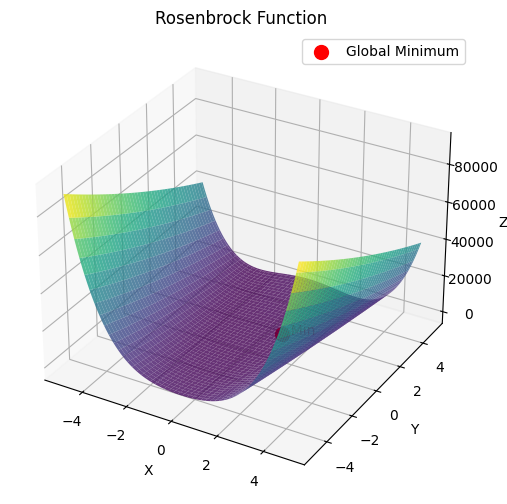

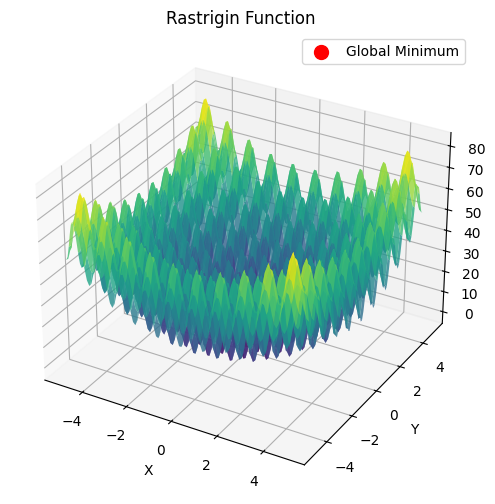

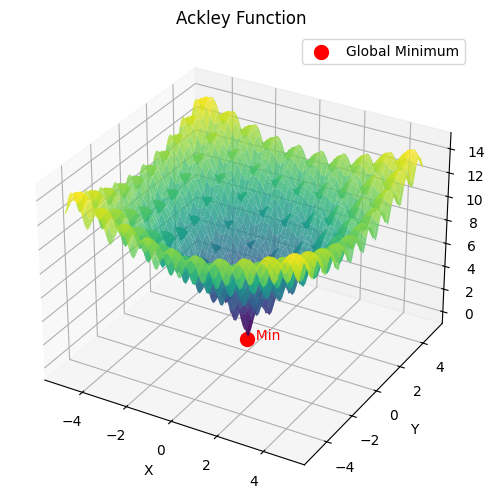

In [3]:
def plot_function(f, title, minima):
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([f([X[i, j], Y[i, j]]) for i in range(X.shape[0]) for j in range(X.shape[1])]).reshape(X.shape)
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    
    # Plot and label minima
    min_x, min_y = minima
    min_z = f([min_x, min_y])
    ax.scatter(min_x, min_y, min_z, color='red', s=100, label='Global Minimum')
    ax.text(min_x, min_y, min_z, '  Min', color='red')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.show()

plot_function(rosenbrock, 'Rosenbrock Function', (1, 1))
plot_function(rastrigin, 'Rastrigin Function', (0, 0))
plot_function(ackley, 'Ackley Function', (0, 0))


__Nelder-Mead__ (Simplex Method)

In [4]:
print("----Nelder-Mead optimization for Rosenbrock function:----")
result = minimize(rosenbrock, x0=[0,0], method='Nelder-Mead', options={'xatol': 1e-8, 'maxiter': 1000})
# Display results
print(f"Optimization successful: {result.success}")
print(f"Minimum found at: {result.x}")
print(f"Function value: {result.fun:.4f}")
print(f"Iterations: {result.nit}")
print(f"Function evaluations: {result.nfev}")


print("\n----Nelder-Mead optimization for Rastrigin function:----")
result = minimize(rastrigin, x0=np.zeros(2), method='Nelder-Mead', bounds=[(-5.12,5.12)]*2)
# Display results
print(f"Optimization successful: {result.success}")
print(f"Minimum found at: {result.x}")
print(f"Function value: {result.fun:.4f}")
print(f"Iterations: {result.nit}")
print(f"Function evaluations: {result.nfev}")


print("\n----Nelder-Mead optimization for Ackley function:----")
initial_point = np.random.uniform(-5, 5, 2)  # Random starting point in [-5,5]
options = {
    'initial_simplex': None,
    'xatol': 1e-6,
    'fatol': 1e-6,
    'maxiter': 10000,
    'adaptive': True
}
result = minimize(ackley, initial_point, method='nelder-mead', options=options)
# Display results
print(f"Optimization successful: {result.success}")
print(f"Minimum found at: {result.x}")
print(f"Function value: {result.fun:.4f}")
print(f"Iterations: {result.nit}")
print(f"Function evaluations: {result.nfev}")

----Nelder-Mead optimization for Rosenbrock function:----
Optimization successful: True
Minimum found at: [1. 1.]
Function value: 0.0000
Iterations: 110
Function evaluations: 206

----Nelder-Mead optimization for Rastrigin function:----
Optimization successful: True
Minimum found at: [0. 0.]
Function value: 0.0000
Iterations: 4
Function evaluations: 9

----Nelder-Mead optimization for Ackley function:----
Optimization successful: True
Minimum found at: [-2.26886145e-07  4.64818325e-07]
Function value: 0.0000
Iterations: 57
Function evaluations: 111


#### Comparing Every optimization technique for every function

In [3]:
# Define Bounds
bounds = [(-5, 5), (-5, 5)]
x0 = np.random.uniform(-5, 5, 2)

In [18]:
def optimize_function(func, method, bounds, x0=None):
    if method == "Nelder-Mead":
        result = minimize(func, x0=x0, method='Nelder-Mead', options={'maxiter': 1000})
        return result.x, result.fun
    elif method == "CMA-ES":
        es = cma.CMAEvolutionStrategy(x0, 0.5)
        es.optimize(func, iterations=1000)
        return es.result.xbest, es.result.fbest
    elif method == "Simulated Annealing":
        result = dual_annealing(func, bounds)
        return result.x, result.fun


Optimizing Rosenbrock function:
Rosenbrock (Nelder-Mead) -> Best Solution: [0.99999541 0.99999385], Best Value: 9.428032652230973e-10
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=407731, Sun Mar 30 23:48:35 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 8.875079637662425e+01 1.0e+00 6.73e-01  7e-01  9e-01 0:00.0
    2     12 9.937534723450447e+01 1.4e+00 7.52e-01  8e-01  1e+00 0:00.0


    3     18 5.568056126686881e-01 1.6e+00 7.02e-01  6e-01  8e-01 0:00.0
  100    600 1.715030327200671e-13 5.7e+01 2.38e-04  5e-07  1e-06 0:00.1
  105    630 4.653750293501064e-15 5.6e+01 9.30e-05  1e-07  2e-07 0:00.1
Rosenbrock (CMA-ES) -> Best Solution: [0.99999998 0.99999995], Best Value: 1.2127767215086085e-15
Rosenbrock (Simulated Annealing) -> Best Solution: [0.999997 0.999994], Best Value: 8.981059995262747e-12

Optimizing Rastrigin function:
Rastrigin (Nelder-Mead) -> Best Solution: [2.9848608  1.98990209], Best Value: 12.934432457529672
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=413914, Sun Mar 30 23:48:36 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 2.611340177471345e+01 1.0e+00 4.46e-01  4e-01  5e-01 0:00.0
    2     12 1.585415333489849e+01 1.3e+00 4.41e-01  4e-01  5e-01 0:00.0
    3     18 1.794101444744117e+01 1.7e+00 4.71e-01  4e-01  4e-01 0:00.0
  100    600 9.949590570944551e-01 1.1e+00 7.62e-05  8e-08  9e-08 

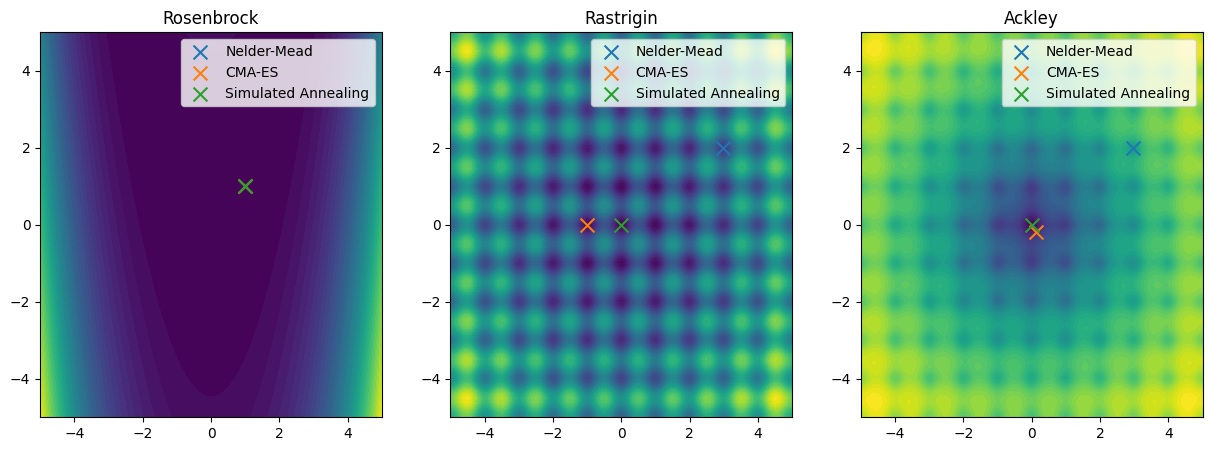

In [19]:
methods = ["Nelder-Mead", "CMA-ES", "Simulated Annealing"]
functions = {"Rosenbrock": rosenbrock, "Rastrigin": rastrigin, "Ackley": ackley}
results = {}

for fname, func in functions.items():
    results[fname] = {}
    print(f"\nOptimizing {fname} function:")
    for method in methods:
        best_x, best_f = optimize_function(func, method, bounds, x0)
        results[fname][method] = (best_x, best_f)
        print(f"{fname} ({method}) -> Best Solution: {best_x}, Best Value: {best_f}")

# Plot Trajectories
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (fname, func) in enumerate(functions.items()):
    ax = axes[i]
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[func([xi, yi]) for xi, yi in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])
    
    ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    ax.set_title(fname)
    for method in methods:
        best_x, _ = results[fname][method]
        ax.scatter(best_x[0], best_x[1], label=method, s=100, marker='x')
    ax.legend()
plt.show()

#### __Task 2:__ Hyperparameter Tuning in Machine Learning (2 marks)
1. Apply the three optimization methods to tune hyperparameters for a machine learning model:   
• Consider a Support Vector Machine (SVM) for classification on the MNIST dataset.   
• Optimize hyperparameters such as kernel type, regularization parameter (C), and gamma.   
• Compare the test accuracy obtained using each optimization technique.   

2. Analyze and compare the efficiency of each method in terms of:   
• Number of function evaluations required to reach optimal hyperparameters.    
• Performance stability over multiple runs.   
• Final classification accuracy.  

In [6]:
# Load and preprocess the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target.astype(int)

X = X / 255.0

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the objective function for hyperparameter tuning
def objective(params, kernel):
    C, gamma = params
    # Ensure parameters are positive
    C = max(C, 1e-6)
    gamma = max(gamma, 1e-6)
    
    # Train an SVM classifier with given hyperparameters
    svm = SVC(kernel=kernel, C=C, gamma=gamma)
    svm.fit(X_train[:500], y_train[:500])  # Use a subset of the training data for faster optimization
    
    # Evaluate accuracy on validation set (subset of test data)
    y_pred = svm.predict(X_test[:100])
    accuracy = accuracy_score(y_test[:100], y_pred)
    
    # Return negative accuracy (since we minimize in optimization algorithms)
    return -accuracy

# Define bounds for hyperparameters (C and gamma)
bounds = [(1e-3, 10), (1e-4, 1)]

# Run hyperparameter tuning using Nelder-Mead, Simulated Annealing, and CMA-ES
results = {}
methods = ["Nelder-Mead", "Dual Annealing", "CMA-ES"]

for kernel in ["rbf", "poly"]:  # You can extend this to other kernels like 'poly' or 'sigmoid'
    print(f"\nTuning hyperparameters for SVM with {kernel} kernel:")
    
    # Nelder-Mead Optimization
    initial_guess = [1.0, 0.01]
    nelder_result = minimize(
        lambda params: objective(params, kernel),
        x0=initial_guess,
        method="Nelder-Mead",
        options={"maxiter": 50}
    )
    
    # Dual Annealing Optimization (Simulated Annealing)
    da_result = dual_annealing(
        lambda params: objective(params, kernel),
        bounds=bounds,
        maxiter=50
    )
    
    # CMA-ES Optimization
    cma_result = cma.fmin(
        lambda params: objective(params, kernel),
        x0=[1.0, 0.01],
        sigma0=0.3,
        options={"bounds": [list(b[0] for b in bounds), list(b[1] for b in bounds)], "maxiter": 50}
    )
    
    # Store results for comparison
    results[kernel] = {
        "Nelder-Mead": {"Params": nelder_result.x.tolist(), "Accuracy": -nelder_result.fun},
        "Dual Annealing": {"Params": da_result.x.tolist(), "Accuracy": -da_result.fun},
        "CMA-ES": {"Params": cma_result[0].tolist(), "Accuracy": -cma_result[1]},
    }

# Display results for all methods and kernels
for kernel in results:
    print(f"\nResults for {kernel} kernel:")
    for method in results[kernel]:
        print(f"{method}: Params={results[kernel][method]['Params']}, Accuracy={results[kernel][method]['Accuracy']:.4f}")



Tuning hyperparameters for SVM with rbf kernel:
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=467609)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -8.100000000000001e-01 1.0e+00 3.01e-01  2e-01  3e-01 0:00.5
    2     12 -1.900000000000000e-01 1.4e+00 2.36e-01  2e-01  2e-01 0:01.0
    3     18 -8.300000000000000e-01 1.3e+00 2.02e-01  1e-01  2e-01 0:01.4
   10     60 -8.400000000000000e-01 3.2e+00 1.21e-01  3e-02  1e-01 0:04.6
   20    120 -8.600000000000000e-01 6.0e+00 3.06e-02  2e-03  2e-02 0:08.8
   33    198 -8.600000000000000e-01 1.3e+01 1.24e-02  3e-04  4e-03 0:14.1
   37    222 -8.600000000000000e-01 2.0e+01 6.81e-03  1e-04  2e-03 0:15.7
termination on tolflatfitness=1 (Mon Mar 31 00:17:13 2025)
final/bestever f-value = -8.600000e-01 -8.600000e-01 after 223/61 evaluations
incumbent solution: [1.2505617421950324, 0.0014823136288836022]
std deviation: [0.0018808890403726277, 9.908629038877246e-05]

Tuning hyperparameters for SVM wi